# Calculate the Friis equation for each network and plot the results
### The Friis equation is given by:
# $P_r = \frac{P_t G_t G_r \lambda^2}{(4 \pi d)^2}$
- $P_r$ is the received power
- $P_t$ is the transmitted power
- $G_t$ is the gain of the transmitting antenna
- $G_r$ is the gain of the receiving antenna
- $\lambda$ is the wavelength
- $d$ is the distance between the antennas
# $G_i(w) = \frac{4 \pi R}{\lambda} |S_{21}(w)|$
- per Mohammad's formulas

In [ ]:
# install dependencies if not already installed
pip install scikit-rf matplotlib numpy scipy NuRadioReco --quiet

In [1]:
import skrf as rf
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter1d
from NuRadioReco.utilities import units
import os
import glob

In [3]:
# grab all files from both directories
aug_4 = True
# aug_4 = False

if aug_4:
    HPol_path = 'Data/Port1inNWhole_Port2inShole_ST35_HPOL_VNA'
    VPol_path = 'Data/Port1inNWhole_Port2inShole_ST35_VPOL_VNA'
    s2p_files_HPol = glob.glob(os.path.join(HPol_path, '*.s2p'))
    s2p_files_VPol = glob.glob(os.path.join(VPol_path, '*.s2p'))
    # Load all s2p files into a single list of Network objects
    networks = [rf.Network(file) for file in s2p_files_HPol + s2p_files_VPol]

else:
    path = 'Data/Full Set/020825/Port1inNEhole_Port2inShole_ST25_VNA'
    s2p_files_full = glob.glob(os.path.join(path, '*.s2p'))
    networks = [rf.Network(file) for file in s2p_files_full]

networks = sorted(networks, key=lambda x: (x.name[:-2], int(x.name[-2:]) if x.name[-2:].isdigit() else float('inf')))

d = 34.63  # Distance between the holes in meters

In [4]:
# dir = 'Gain Plots/'
#
# if update_gain:
#     for net in networks:
#         # print(net.name)
#         # if net.name != 'Aug4_hpol_down_25m':
#         #     continue  # Skip this network for now
#         plt.figure(figsize=(10, 4))
#
#         # calculate the gain of the antenna from the S12 parameter
#         wavelength = 3e8 / net.f  # Wavelength in meters
#         G_i = (4 * np.pi * d) / wavelength * np.abs(net.s[:, 1, 0])
#
#
#         smoothed_G_i = gaussian_filter1d(G_i, sigma=20)  # Smooth the gain
#         # plot the gain
#         plt.plot(net.f, 10 * np.log10(G_i), label=net.name, linewidth=0.3)
#         plt.plot(net.f, 10 * np.log10(smoothed_G_i), label=net.name + ' (smoothed)', linewidth=1)
#         plt.title('Gain of Antenna from S12 Parameter')
#         plt.xlabel('Frequency (Hz)')
#         plt.ylabel('Gain (dB)')
#         plt.grid()
#         # plt.savefig(f'{dir}{net.name[5:]}.png', dpi=300, bbox_inches='tight')
#         plt.savefig(f'{dir}{net.name}.png', dpi=300, bbox_inches='tight')
#         plt.close()

# $\mathcal{H}_i(w) = \lambda \sqrt{\frac{Z_0}{4 \pi Z_f} G_i(w)}$m
- $Z_0$ is 50 Ohms
- $Z_f$ is the free space impedance (377 Ohms)
- $G_i(w)$ is the gain of the antenna


In [5]:
# Constants
Z_f = 377  # Free space impedance in Ohms
# n = 1.32  # Refractive index of the medium (Greenland Firn)
Z_0 = 50.0  # Characteristic impedance of the antenna in Ohms

In [6]:
def get_RVEL(network, G_i):
    wavelength = 3e8 / network.f  # Wavelength in meters
    RVEL = wavelength * np.sqrt(((Z_0) / (4 * np.pi * Z_f)) * G_i)  # Antenna impedance calculation

    return RVEL

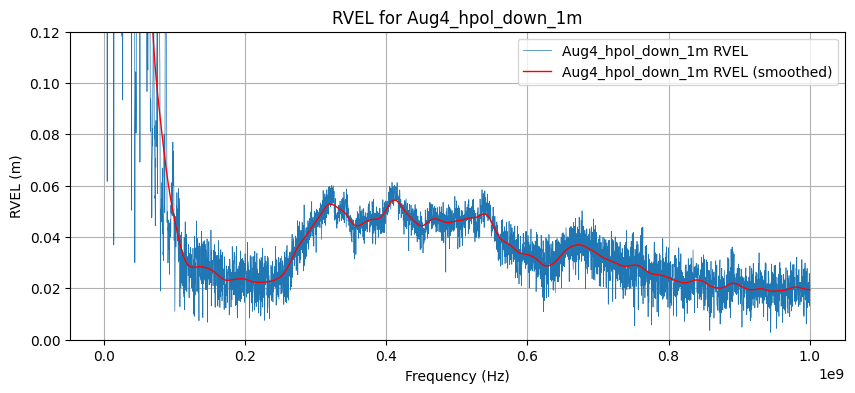

In [20]:
ff = np.linspace(50 * units.MHz, 1 * units.GHz, 1000)
RVEL_sigma = 30

for net in networks:
    if net != networks[0]:
        continue
    wavelength = 3e8 / net.f  # Wavelength in meters
    G_i = (4 * np.pi * d) / wavelength * np.abs(net.s[:, 1, 0])
    RVEL = get_RVEL(net, G_i)
    smoothed_RVEL = gaussian_filter1d(RVEL, sigma=RVEL_sigma)  #

    plt.figure(figsize=(10, 4))
    plt.plot(net.f, RVEL, label=net.name + ' RVEL', linewidth=0.5)
    plt.plot(net.f, smoothed_RVEL, label=net.name + ' RVEL (smoothed)', linewidth=1, color='red')

    if 'hpol' in net.name:
        plt.ylim(0, 0.12)  # Set y-axis limits to focus on the RVEL
    else:
        plt.ylim(0, 0.25)  # Set y-axis limits to focus on the RVEL

    plt.title(f'RVEL for {net.name}')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('RVEL (m)')
    plt.grid()
    plt.legend()
